In [27]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedPipeline
from text3d2video.attn_processors.style_aligned_attn import (
    StyleAlignedAttentionProcessor,
)
from diffusers import DDIMScheduler
from diffusers import DPMSolverMultistepScheduler

sd_repo = "runwayml/stable-diffusion-v1-5"

dtype = torch.float16
device = torch.device("cuda")

pipe: StyleAlignedPipeline = StyleAlignedPipeline.from_pretrained(
    sd_repo, torch_dtype=dtype
).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


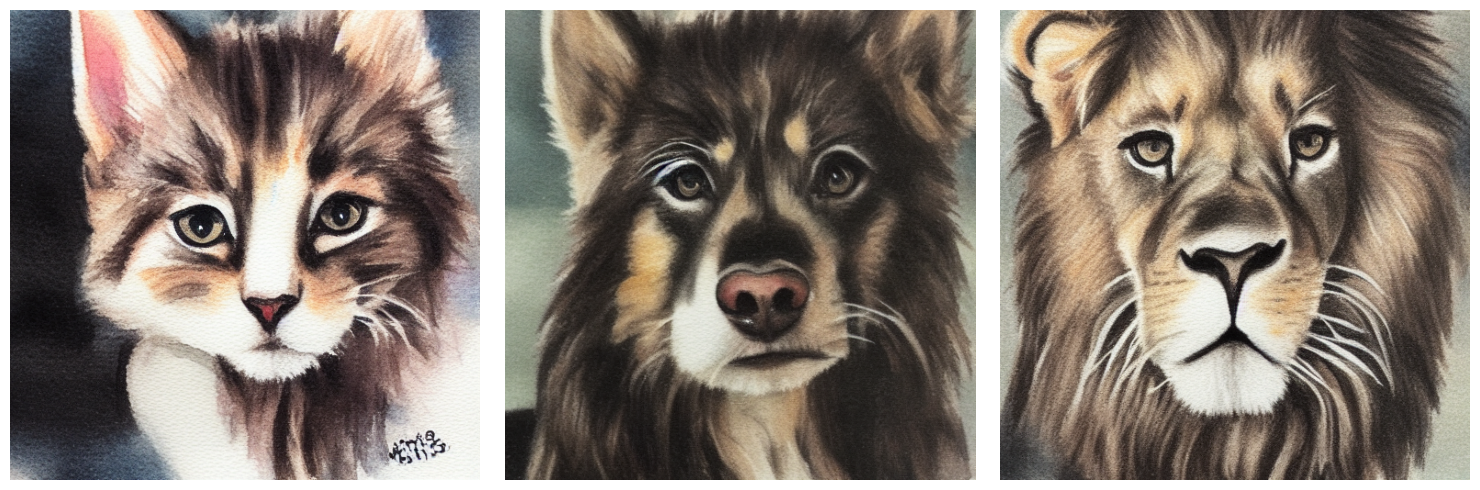

In [40]:
from pathlib import Path
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedLogger

prompts = ["A kitten watercolor", "Dog", "Lion Drawing"]

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

attn_processor = StyleAlignedAttentionProcessor(
    pipe.unet,
    ref_index=0,
    attend_to="all",
    adain_self_features=False,
    layers=module_paths,
)

pipe.unet.set_attn_processor(attn_processor)
pipe.attn_processor = attn_processor

gen = torch.Generator(device=device)
gen.manual_seed(0)

logger = StyleAlignedLogger(Path("data.h5"), enabled=True)
logger.path_greenlist = module_paths
logger.delete_data()
logger.begin_recording()

ims = pipe(
    prompts,
    num_inference_steps=20,
    generator=gen,
    guidance_scale=10,
    logger=logger,
)

display_ims(ims, scale=5)

logger.end_recording()

In [41]:
logger = pipe.logger
ts = logger.noise_level_greenlist
denoising_ts = ts[0:-1]
# logger.print_datasets()
logger.memory_usage()

2.340941024

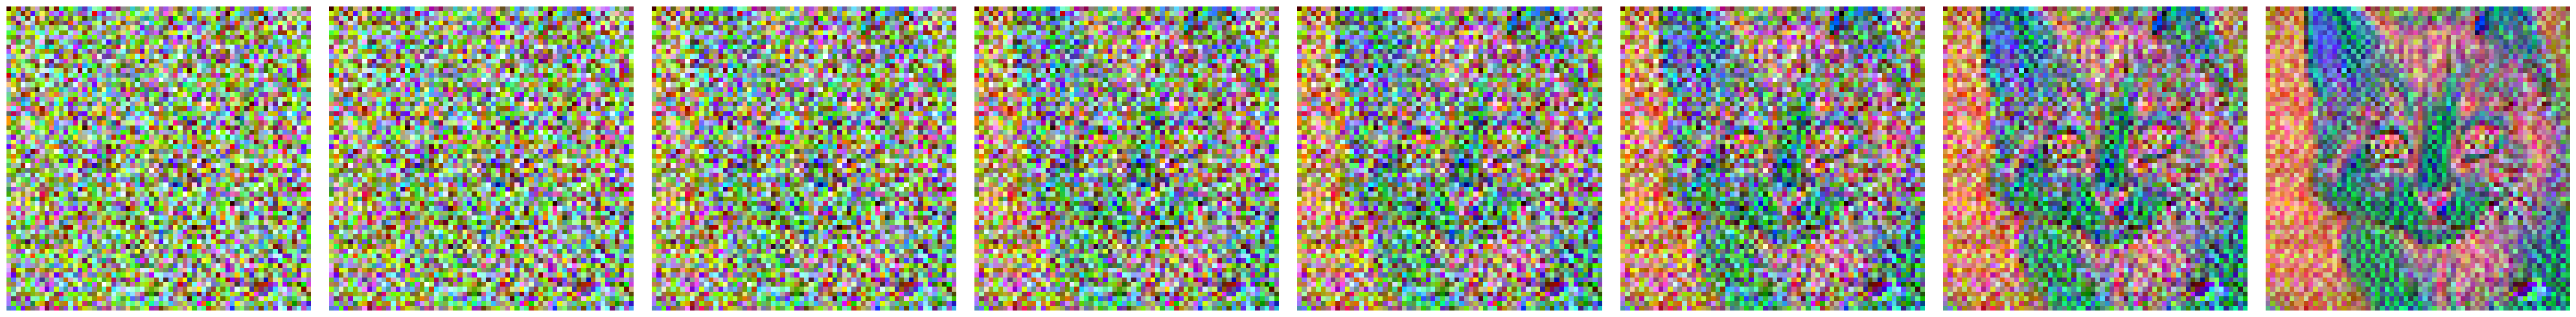

In [42]:
from einops import rearrange
from text3d2video.feature_visualization import RgbPcaUtil


latents = [logger.latents_writer.read_latent(t, 0) for t in ts]
latents = torch.stack(latents)

latent_features = rearrange(latents[-1], "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(latent_features)

latents_pca = [pca.feature_map_to_rgb_pil(latent) for latent in latents]

display_ims(latents_pca, scale=5)